## Restricted Boltzmann Machine that recommends music artists to a user on a basis of artists that this user has already scored. Yahoo! dataset (Tensorflow)

### Information about the dataset

- Number of inputs: **>150 000 000**, for the project only 1.55 million is used
- Total number of music artists: **97 956**
- Dataset: https://webscope.sandbox.yahoo.com/catalog.php?datatype=r&did=1 <br>
A permission to use this data set for non-commercial usage was provided by Yahoo

### Data preprocesing stage

**Import libraires** 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

**Import datasets** 

In [2]:
music_rat = pd.read_csv('data/part1.txt', sep=',', header=None)
music_art = pd.read_csv('data/artists.txt', sep='::', header=None)

First column is the id of a user, second one is the id of an artist and the lest one is a score that this user gave to this artist

In [3]:
music_rat.head()

,0,1,2
0,1,1000125,90
1,1,1006373,100
2,1,1006978,90
3,1,1007035,100
4,1,1007098,100


In [4]:
music_art.head()

,0,1
0,-100,Not Applicable
1,-99,Unknown Artist
2,1000001,"Bobby ""O"""
3,1000002,"Jimmy ""Z"""
4,1000003,'68 Comeback


**Naming columns**

In [5]:
music_rat.columns = ["UserID", "ArtistID", "score"]
music_art.columns = ["ArtistID", "Name"]

**Remove a special condition (don't turn again)**

In [6]:
music_rat = music_rat[music_rat["score"] < 255] 

In [7]:
len(music_rat)

1550379

The total number of ratings to be used is: **1550379**

**Add index to every artist**

In [8]:
music_art["List Index"] = music_art.index

**Combune data of two dataframes on a unique artist ID**

In [9]:
data_combined = pd.merge(music_rat, music_art, on="ArtistID")
data_combined = data_combined.drop(["Name"], 1)
data_combined.head(4)

,UserID,ArtistID,score,List Index
0,1,1000125,90,123
1,5,1000125,90,123
2,10,1000125,90,123
3,21,1000125,90,123


**Group data by User and create a template to be used by a neural networ** <br>
Every input will be a user with all of ratings of artists. If user did not rate an artist, a very small number is put (0.000000001).

In [10]:
user_Group = data_combined.groupby('UserID')
TotalUsers = 3500
X = []
for userID, curUser in user_Group:
    temp = [0.000000001]*len(music_art)
    for num, artist in curUser.iterrows():
        temp[artist["List Index"]] = artist["score"]/100
    X.append(temp)
    if TotalUsers == 0:
        break
    TotalUsers -= 1

### Create a neural network

**Placeholders for visible, hidden units, weights** <br>
Number of hidden units selected is 30

In [11]:
hiddenUnits = 30
visibleUnits = len(music_art)
vb = tf.placeholder("float", [visibleUnits]) #Number of unique movies
hb = tf.placeholder("float", [hiddenUnits]) #Number of features we're going to learn
W = tf.placeholder("float", [visibleUnits, hiddenUnits])

**Input Processing**

In [12]:
v0 = tf.placeholder("float", [None, visibleUnits])
_h0= tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

**Reconstruction**

In [13]:
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

#Learning rate
alpha = 1.0
#Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
#Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

**Create methods to update the weights and biases**

In [14]:
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

**Cost function to upddate a neural network**

In [15]:
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

**Initialize weights, units with zeros** <br>
Initializing with zeros give better results

In [16]:
#Current weight
cur_w = np.ones([visibleUnits, hiddenUnits], np.float32)
#Current visible unit biases
cur_vb = np.ones([visibleUnits], np.float32)
#Current hidden unit biases
cur_hb = np.ones([hiddenUnits], np.float32)
#Previous weight
prv_w = np.ones([visibleUnits, hiddenUnits], np.float32)
#Previous visible unit biases
prv_vb = np.ones([visibleUnits], np.float32)
#Previous hidden unit biases
prv_hb = np.ones([hiddenUnits], np.float32)

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Number of epochs: 15 <br>
Batch size: 100

In [18]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(X), batchsize), range(batchsize, len(X), batchsize)):
        batch = X[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_nb
    errors.append(sess.run(err_sum, feed_dict={v0: X, W: cur_w, vb: cur_vb, hb: cur_nb}))
    print ("Epoch: ", i, "Error: ", errors[-1])

Epoch:  0 Error:  0.028933931
Epoch:  1 Error:  0.014132052
Epoch:  2 Error:  0.0056618773
Epoch:  3 Error:  0.00159936
Epoch:  4 Error:  0.0008607011
Epoch:  5 Error:  0.0006886218
Epoch:  6 Error:  0.0006366985
Epoch:  7 Error:  0.0006066197
Epoch:  8 Error:  0.0005879356
Epoch:  9 Error:  0.00057767844
Epoch:  10 Error:  0.0005672875
Epoch:  11 Error:  0.00056338
Epoch:  12 Error:  0.00055596017
Epoch:  13 Error:  0.00055274775
Epoch:  14 Error:  0.0005466973


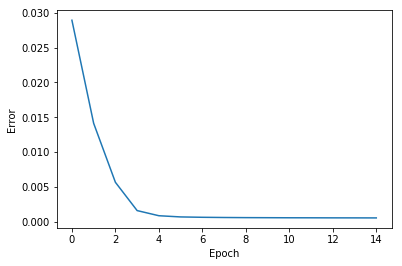

In [19]:
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [20]:
#Selecting the input user with id 200
inputUser = [X[200]]

In [21]:
#Feeding in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

In [22]:
scores_200 = music_art
scores_200["Recommendation Score"] = rec[0]
scores_200.sort_values(["Recommendation Score"], ascending=False).head(20)

,ArtistID,Name,List Index,Recommendation Score
43320,1044487,Sean Paul,43320,0.676597
30074,1030879,Missy Elliott,30074,0.491117
48579,1051565,Beyonce,48579,0.455132
13920,1014312,Lil' Kim,13920,0.415152
95938,1099097,Chingy,95938,0.375088
32641,1033451,DMX,32641,0.370788
30235,1031044,Jagged Edge,30235,0.366607
12835,1013213,Jay-Z,12835,0.365482
50262,1053407,Ludacris,50262,0.357813
270,1000276,Aaliyah,270,0.351715
